# Bootstrap Ranking Example

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from matplotlib.lines import Line2D

from htc.evaluation.ranking import BootstrapRanking
from htc.models.common.MetricAggregation import MetricAggregation
from htc.settings import settings
from htc.utils.Config import Config

## Select runs to compare
Algorithm comparison based on bootstraping similar to [challengeR](https://github.com/wiesenfa/challengeR). In our case, one algorithm is usually one training run.

In [2]:
def load_data(run_dir: Path, name: str) -> pd.DataFrame:
    config = Config(run_dir / "config.json")
    df = pd.read_pickle(run_dir / "test_table.pkl.xz")
    df = MetricAggregation(df, config=config).grouped_metrics()
    df["run_folder"] = name

    return df


run_dir1 = settings.training_dir / "image" / "2022-02-15_20-00-11_generated_default_seed=0"
run_dir2 = settings.training_dir / "image" / "2022-02-15_20-00-11_generated_default_seed=1"
df = pd.concat([load_data(run_dir1, "seed=0"), load_data(run_dir2, "seed=1")])

ranking = BootstrapRanking(df, algorithm="run_folder", case="label_name", value="dice_metric", task=None)

In [3]:
ranking

## Bubble plot
Note: The plot code below may not work for all cases yet, so you need to adjust it to your case.

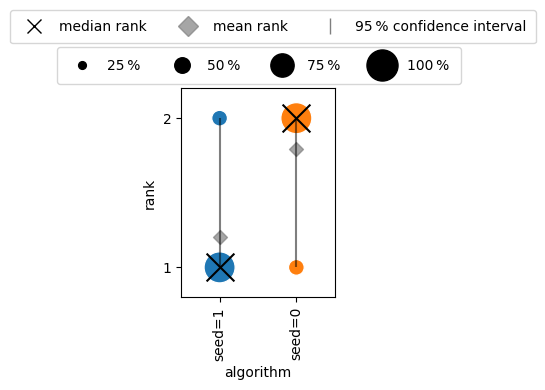

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3), constrained_layout=True)

# Scatter plot
alg_order = list(ranking.statistics.algorithm.values)  # determine ordering
alg_positions = list(range(len(alg_order)))
df_counts = ranking.counts.sort_values(by="algorithm", key=lambda column: column.map(lambda e: alg_order.index(e)))
base_scaling = 500
sns.scatterplot(
    df_counts,
    x="algorithm",
    y="rank",
    hue="algorithm",
    size="count",
    sizes={x: base_scaling * x / df_counts["count"].max() for x in df_counts["count"]},
    ax=ax,
)

# Confidence intervals, median and mean rank
for _, series in ranking.statistics.iterrows():
    ax.vlines(alg_order.index(series["algorithm"]), series["min_CI"], series["max_CI"], colors="black", alpha=0.5)
    ax.scatter(
        alg_order.index(series["algorithm"]), series["median_rank"], marker="x", s=0.8 * base_scaling, color="black"
    )
    ax.scatter(
        alg_order.index(series["algorithm"]),
        series["mean_rank"],
        marker="D",
        s=0.1 * base_scaling,
        color="gray",
        alpha=0.7,
    )

# Formatting
ax.xaxis.set_major_locator(ticker.FixedLocator(alg_positions))
ax.set_xticklabels(alg_order, rotation=90)
ax.get_legend().set_visible(False)
ax.set_yticks(list(range(1, len(alg_order) + 1)))
ax.set_ylim([0.8, len(alg_order) + 0.2])
ax.set_xlim([-0.5, len(alg_order) - 0.5])

#  Bubble legend
bubble_handles = []
for p in [0.25, 0.5, 0.75, 1]:
    bubble_handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="black",
            label=f"{p * 100:.0f} %",
            # scatter size = markersize**2 (https://stackoverflow.com/a/47403507)
            markersize=p * np.sqrt(500),
            linewidth=0,
        )
    )

plt.figlegend(
    handles=bubble_handles,
    loc="upper center",
    borderaxespad=0.8,
    ncol=5,
    labelspacing=0.0,
    prop={"size": 10},
    bbox_to_anchor=(0.60, 1.16),
    borderpad=0.8,
    markerscale=1,
)

# Icon legend
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="x",
        color="black",
        label="median rank",
        markerfacecolor="black",
        markersize=10,
        linewidth=0,
    ),
    Line2D(
        [0],
        [0],
        marker="D",
        color="gray",
        label="mean rank",
        markerfacecolor="gray",
        markersize=10,
        linewidth=0,
        alpha=0.7,
    ),
    Line2D(
        [0],
        [0],
        marker="|",
        color="black",
        linestyle="None",
        label="95 % confidence interval",
        markerfacecolor="gray",
        markersize=12,
        linewidth=12,
        alpha=0.5,
    ),
]

plt.figlegend(
    handles=legend_elements,
    loc="upper center",
    borderaxespad=0.7,
    ncol=3,
    labelspacing=0.0,
    prop={"size": 10},
    bbox_to_anchor=(0.67, 1.28),
    borderpad=0.7,
);